# Exploratory Data Analysis (EDA)
## Risk-Aware Material Allocation Optimization
**Group 7**

This notebook performs a detailed exploratory data analysis on:
- Retail demand data (FreshRetailNet via Hugging Face)
- Supply chain logistics data (synthetic)

The objective is to extract meaningful insights on demand variability,
supply-side risk, and their interaction to inform downstream simulation
and optimization.

## 1. Imports and Setup

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset

pd.set_option('display.max_columns', 50)
plt.rcParams['figure.figsize'] = (10, 4)

## 2. Load Datasets

In [20]:

# Load demand data (FreshRetailNet)
demand_df = pd.read_csv('../data/freshretailnet_full.csv')

# Demand data (FreshRetailNet)
#dataset = load_dataset("Dingdong-Inc/FreshRetailNet-50K")
#demand_df = dataset["train"].to_pandas()

# Supply chain logistics data
supply_df = pd.read_csv("../data/dynamic_supply_chain_logistics_dataset.csv")

print("Demand data shape:", demand_df.shape)
print("Supply data shape:", supply_df.shape)


Demand data shape: (4500000, 19)
Supply data shape: (32065, 26)


## 3. Data Schema and Basic Structure

In [28]:
# Convert date columns
demand_df["dt"] = pd.to_datetime(demand_df["dt"])
supply_df["timestamp"] = pd.to_datetime(supply_df["timestamp"])

print(demand_df.dtypes)
print(supply_df.dtypes)

city_id                         int64
store_id                        int64
management_group_id             int64
first_category_id               int64
second_category_id              int64
third_category_id               int64
product_id                      int64
dt                     datetime64[ns]
sale_amount                   float64
hours_sale                     object
stock_hour6_22_cnt              int64
hours_stock_status             object
discount                      float64
holiday_flag                    int64
activity_flag                   int64
precpt                        float64
avg_temperature               float64
avg_humidity                  float64
avg_wind_level                float64
dtype: object
timestamp                          datetime64[ns]
vehicle_gps_latitude                      float64
vehicle_gps_longitude                     float64
fuel_consumption_rate                     float64
eta_variation_hours                       float64
traffic_conges

## 3. Demand Hierarchy and Feasibility

In [29]:
print("Unique cities:", demand_df["city_id"].nunique())
print("Unique stores:", demand_df["store_id"].nunique())
print("Unique products:", demand_df["product_id"].nunique())
print("Date range:", demand_df["dt"].min(), "to", demand_df["dt"].max())

Unique cities: 18
Unique stores: 898
Unique products: 865
Date range: 2024-03-28 00:00:00 to 2024-06-25 00:00:00


**Insight:**
Cities (18) provide a clean and defensible proxy for plants in a multi-plant
allocation setting.

## 4. Aggregation-First Demand Analysis

Number of days: 90


dt
2024-03-28    35787.337
2024-03-29    34893.476
2024-03-30    47995.157
2024-03-31    49950.534
2024-04-01    35607.989
Name: sale_amount, dtype: float64

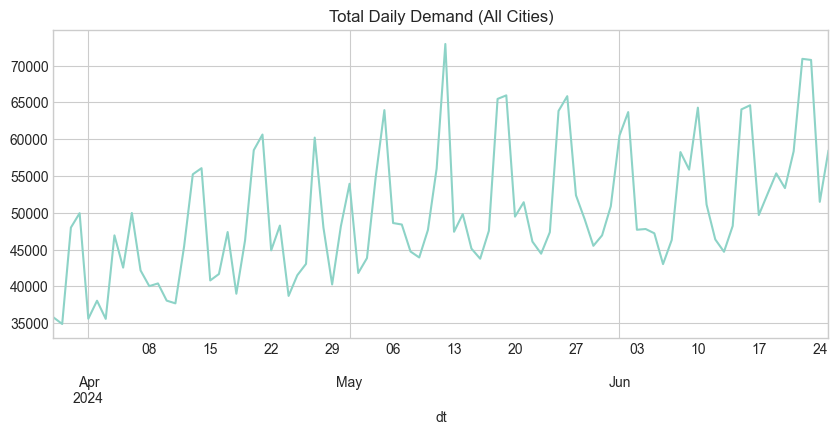

In [30]:
# Global daily demand
daily_demand = demand_df.groupby("dt")["sale_amount"].sum()

print("Number of days:", daily_demand.shape[0])
display(daily_demand.head())

daily_demand.plot(title="Total Daily Demand (All Cities)")
plt.show()

**Insight:**
Demand shows strong volatility and spikes, indicating that average-based
planning would underestimate risk.

In [36]:
city_daily = (
    demand_df
    .groupby(["dt", "city_id"])["sale_amount"]
    .sum()
    .reset_index()
)

print(
    city_daily
    .groupby("city_id")["sale_amount"]
    .std()
    .describe()
)

count      18.000000
mean      516.676411
std       996.912011
min        11.316237
25%        86.327537
50%       126.765121
75%       485.844642
max      4331.895035
Name: sale_amount, dtype: float64


**Insight:**
Demand variability differs significantly across cities, motivating
plant-specific buffers or risk adjustments.

## 5. Supply Chain Logistics EDA

In [37]:
metrics = [
    "warehouse_inventory_level",
    "lead_time_days",
    "shipping_costs",
    "delay_probability",
    "delivery_time_deviation"
]

print(supply_df[metrics].describe())
print(supply_df["risk_classification"].value_counts())

       warehouse_inventory_level  lead_time_days  shipping_costs  \
count               3.206500e+04    32065.000000    32065.000000   
mean                2.992547e+02        5.227502      459.374452   
std                 3.234435e+02        4.523085      312.183487   
min                 1.322210e-12        1.000000      100.000000   
25%                 1.605163e+01        1.237490      154.017124   
50%                 1.572880e+02        3.297654      388.996911   
75%                 5.405980e+02        8.625720      753.007203   
max                 9.999993e+02       14.999995      999.999853   

       delay_probability  delivery_time_deviation  
count       32065.000000             32065.000000  
mean            0.699077                 5.177648  
std             0.324514                 4.157988  
min             0.000003                -1.999998  
25%             0.456009                 1.269197  
50%             0.839599                 6.113662  
75%             0.98239

**Insight:**
High-risk scenarios dominate the logistics data, making it suitable for
stress-testing allocation decisions.

## 6. Demand–Supply Integration (Actual Merge)

In [38]:
# Aggregate supply data to daily level
supply_df["date"] = supply_df["timestamp"].dt.date
supply_daily = (
    supply_df
    .groupby("date")[metrics]
    .mean()
    .reset_index()
)
supply_daily["date"] = pd.to_datetime(supply_daily["date"])

# Merge with city-level demand
merged_df = city_daily.merge(
    supply_daily,
    left_on="dt",
    right_on="date",
    how="left"
)

display(merged_df.head())
print("Merged shape:", merged_df.shape)

,dt,city_id,sale_amount,date,warehouse_inventory_level,lead_time_days,shipping_costs,delay_probability,delivery_time_deviation
0,2024-03-28,0,19833.850,2024-03-28,216.151037,4.666965,447.665952,0.670712,3.851315
1,2024-03-28,1,300.250,2024-03-28,216.151037,4.666965,447.665952,0.670712,3.851315
2,2024-03-28,2,282.040,2024-03-28,216.151037,4.666965,447.665952,0.670712,3.851315
3,2024-03-28,3,1424.279,2024-03-28,216.151037,4.666965,447.665952,0.670712,3.851315
4,2024-03-28,4,818.660,2024-03-28,216.151037,4.666965,447.665952,0.670712,3.851315


Merged shape: (1620, 9)


**Insight:**
Each city-day demand observation is now augmented with contemporaneous
supply-side cost and risk signals.

In [45]:
merged_df["risk_bucket"] = pd.cut(
    merged_df["delay_probability"],
    bins=[0, 0.3, 0.6, 1.0],
    labels=["Low", "Medium", "High"]
)

display(
    merged_df
    .groupby("risk_bucket",observed=False)["sale_amount"]
    .agg(["mean", "std", "count"])
)

,mean,std,count
risk_bucket,,,
Low,NaN,NaN,0
Medium,2816.244236,6075.350567,216
High,2767.344752,5978.787301,1404


## 7. Data Gaps and Implications

**Identified gaps:**
- No real plant-level inventory history
- No inter-plant transfer records
- Short demand window (~3 months)
- Synthetic logistics risk labels

**Implication:**
Robustness must be evaluated through scenario-based simulation rather than
purely predictive models.